In [4]:
#import neccesary libraries

#library for reading data from file
import gzip
#common libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

#data visualization libraries
import matplotlib.pyplot as plt

#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
#libraries for data vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


#libraries for data pre-processing and NLP
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\janko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
#Modified code from Web Data: Amazon reviews
def parse(filename):
  f = gzip.open(filename, 'r')
  entry = {}
  for l in f:
    l = l.decode('utf8').strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

#create list with dictionaries, from which we will create dataframe
data = []
for e in parse("data\Cell_Phones_&_Accessories.txt.gz"):
  data.append(e)


In [6]:
#read the data as pandas dataframe
df = pd.DataFrame(data)
#rename columns
df.columns = ['productID','product','price','userID','profile','helpfulness','score','date','summary','text']

#Replace all unknown values with None
df = df.replace({'unknown': None})

#Convert column types
df[['price','score','date']] = df[['price','score','date']].apply(pd.to_numeric)
df['date'] = pd.to_datetime(df['date'], unit='s')
df[['productID','product','userID','profile','helpfulness','summary','text']] = \
    df[['productID','product','userID','profile','helpfulness','summary','text']].astype("string")


## Review classification ##

As a first thing, I decided to build simply review classification. I would like to create the model, which based on text review will clasify the user opinion as <i>positive</i> or <i>negative</i>.

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

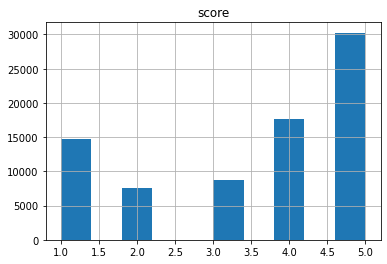

In [7]:
#very intuitive plot of scores distribution of all products
df.hist(column='score')

I decided to simpy divided reviews into two groups such that all reviews with $score > 3.0$ would be classify as <i>positive</i> and all others where $score <= 3.0$ as a <i>negative</i> one 

In [8]:
#select from dataframe review text and label it based on score
df['label'] = np.where(df['score'] > 3.0, 1, 0)
#from main dataframe we select only text and label column, other columns are not needed for us
reviews = df[['text','label']]
reviews.style.set_properties(subset=['text'], **{'width': '300px'})
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78931 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 925.1 KB


In [9]:
#we have one example, when text attribute is null, therefore we delete it
reviews.dropna(subset=['text'], inplace=True)
reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78930 entries, 0 to 78929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78930 non-null  string
 1   label   78930 non-null  int32 
dtypes: int32(1), string(1)
memory usage: 1.5 MB


positive examples: 60.78%
negative examples: 39.22%


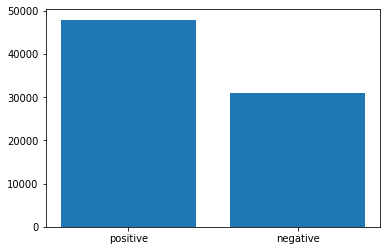

In [10]:
#Count examples of both groups
x = reviews['label'].value_counts()
plt.bar(['positive','negative'], x)
print("positive examples: {:2.2%}".format(x[1]/len(reviews)))
print("negative examples: {:2.2%}".format(x[0]/len(reviews)))

The data shows, that there are many more positive examples than negative one, but still our data is quite balanced, therefore we are not obligatorate to perform any data-balancing techniques.

#### Pre-processing data ####

Important thing in case of working with text data is to preprocess it. It would make our data more clear and in result the model will be more efficient.

In [11]:
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text.split()

to_remove = stopwords.words('english')

def remove_stopword(text):
    return np.setdiff1d(text, to_remove)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    output = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(output)
    

In [12]:
#TODO: preprocess wszystkie dane naraz, rozdzielic na x_train, x_test, y_train, y_test
reviews['text'] = reviews['text'].apply(lambda x: lemmatize_text(remove_stopword(preprocess(x))))
reviews.head()


,text,label
0,actually advice another back buy company custo...,0
1,buy cell compared data definite easily easy gr...,1
2,advertised doesnt go good handset hard little ...,1
3,amazon around benefit better big button c cabl...,1
4,buy cable charger data dont usb,0


#### Vectorize data and split it into training and test sets ####

In [13]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(reviews['text']).toarray()

In [14]:
#Split our data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, reviews['label'],\
    test_size = 0.2, random_state=12)

#### Building ML model ####

As a first model I would like to try LinearSVC

In [16]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(dual=False)
classifier.fit(X_train, y_train)

LinearSVC(dual=False)

In [17]:
#Testing our model
y_predict = classifier.predict(X_test)
y_prob = classifier._predict_proba_lr(X_test)[:,1]

In [22]:
#evaluate the model
print(classification_report(y_test,y_predict)) 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      6190
           1       0.83      0.88      0.85      9596

    accuracy                           0.82     15786
   macro avg       0.81      0.80      0.81     15786
weighted avg       0.82      0.82      0.82     15786

AUC: 0.8890387149734575


|          | Positive | Negative |
|----------|----------|----------|
| Positive | TP=4460  | FP=1730  |
| Negative | FN=1139  | TN=8457  |

$Precision = TP/(TP+FP)$ <br>
$Recall = TP/(TP+FN)$